## CSD->TPF, YAC Prediction, and PBU prediction

Running the logistic regression requires generating CSDs for every play which is a computationally-intensive task (requires ~24 hours). Here we present the code, and the output if it were run. For the true runnable code, refer to the linked github.

In [1]:
# First we write methods that allow the extraction of the coordinates of the players from NFL Tracking Data. Prior to this, we assigned a flat_play_id
# to every play rather than use the (game,play) tag. That id is id.

def get_last_n_frames_coords(id,df_out_merged,n=10):
    df_play = df_out_merged[df_out_merged['flat_play_id'] == id]
    nfl_ids = df_play['nfl_id'].unique()
    frames = df_play['frame_id'].unique()[-n:]
    num_frames=len(frames)


    #Format is (nfl_id, frame_id, x, y,Role)
    coords = []

    for frame in frames:
        df_frame = df_play[df_play['frame_id'] == frame]

        for _, row in df_frame.iterrows():
            coords.append((row['nfl_id'], row['frame_id'], row['x'], row['y'], row['player_role']))

    return coords

def get_first_n_frames_coords(id,df_out_merged,n=10):
    df_play = df_out_merged[df_out_merged['flat_play_id'] == id]
    nfl_ids = df_play['nfl_id'].unique()
    frames = df_play['frame_id'].unique()[0:n]
    num_frames=len(frames)


    #Format is (nfl_id, frame_id, x, y,Role)
    coords = []

    for frame in frames:
        df_frame = df_play[df_play['frame_id'] == frame]

        for _, row in df_frame.iterrows():
            coords.append((row['nfl_id'], row['frame_id'], row['x'], row['y'], row['player_role']))

    return coords

def prep_for_heat(id, df=None, n=2, angle_unit='rad'):
    """
    Prepare receiver + defender final positions and velocities for a heatmap.

    Inputs:
      - id: play id 
      - df: optional DataFrame; if provided, the function calls
            ndb.get_last_n_frames_coords(id_or_coords, df, n=n)
      - n: number of frames to request when calling get_last_n_frames_coords (default 2)
      - angle_unit: 'deg' (default) or 'rad' for velocity direction units.

    Returns:
      (receiver_final_x, receiver_final_y, receiver_final_v_mag, receiver_final_v_dir),
      defender_positions,   # tuple of (x,y) tuples: ((d1x,d1y),(d2x,d2y),...)
      defender_v_mags,      # tuple of mags: (d1_mag, d2_mag, ...)
      defender_v_dirs       # tuple of directions: (d1_dir, d2_dir, ...)

    Notes / assumptions:
      - get_last_n_frames_coords returns a flat list: (nfl_id, frame_id, x, y, player_role)
      - Velocities are computed from the last two frames for each player (if available).
      - If only one frame exists for a player, v_mag = 0 and v_dir = np.nan.
      - Receiver is detected by player_role starting with 'r' (case-insensitive) or containing 'receiver'.
      - Players whose role contains 'ball' or 'football' are ignored.
    """
    

    
    coords = ndb.get_last_n_frames_coords(id, df, n=n)
    
    # Expect coords: list of (nfl_id, frame_id, x, y, player_role)
    # Group by nfl_id, keep tuples of (frame_id, x, y, role)
    players = defaultdict(list)
    for item in coords:
        try:
            nfl_id, frame_id, x, y, role = item
        except Exception:
            # skip malformed entries
            continue
        players[nfl_id].append((frame_id, float(x), float(y), str(role)))

    # Sort each player's frames by frame_id ascending
    for pid in list(players.keys()):
        players[pid].sort(key=lambda t: t[0])

    # Helper to compute velocity from last two frames (or return 0, nan)
    def compute_vel(frames):
        # frames: list of (frame_id, x, y, role) sorted by frame_id asc
        if len(frames) >= 2:
            _, x1, y1, _ = frames[-2]
            _, x2, y2, _ = frames[-1]
            dx = x2 - x1
            dy = y2 - y1
            mag = np.clip(float(math.hypot(dx, dy))*10,0,10.5)
            ang = float(math.atan2(dy, dx))
            if angle_unit == 'deg':
                ang = math.degrees(ang)
            return mag, ang
        else:
            return 0.0, float('nan')

    # Identify receiver: prefer a player whose most-recent role startswith 'r' or contains 'receiver'.
    receiver_pid = None
    receiver_candidate_frame = -1
    for pid, frames in players.items():
        last_role = frames[-1][3].lower() if frames and frames[-1][3] is not None else ''
        if last_role.startswith('r') or 'receiver' in last_role or 'target' in last_role:
            # choose the candidate with the most recent frame (highest frame id)
            last_frame_id = frames[-1][0]
            if last_frame_id >= receiver_candidate_frame:
                receiver_candidate_frame = last_frame_id
                receiver_pid = pid

    # If none found, try to find a player named 'receiver' anywhere in role strings
    if receiver_pid is None:
        for pid, frames in players.items():
            last_role = frames[-1][3].lower() if frames and frames[-1][3] is not None else ''
            if 'receiver' in last_role:
                receiver_pid = pid
                break

    # Prepare receiver outputs
    if receiver_pid is not None:
        rframes = players[receiver_pid]
        recv_x = float(rframes[-1][1])
        recv_y = float(rframes[-1][2])
        recv_v_mag, recv_v_dir = compute_vel(rframes)
    else:
        # fallback: return NaNs if no receiver detected
        recv_x = float('nan')
        recv_y = float('nan')
        recv_v_mag = 0.0
        recv_v_dir = float('nan')

    # Prepare defender lists: exclude receiver and any 'ball'/'football' roles
    defender_positions = []
    defender_v_mags = []
    defender_v_dirs = []

    for pid in sorted(players.keys()):
        if pid == receiver_pid:
            continue
        frames = players[pid]
        # ignore ball/football if role indicates that
        last_role = frames[-1][3].lower() if frames and frames[-1][3] is not None else ''
        if 'ball' in last_role or 'football' in last_role:
            continue
        # final position
        fx = float(frames[-1][1])
        fy = float(frames[-1][2])
        fmag, fdir = compute_vel(frames)
        defender_positions.append((fx, fy))
        defender_v_mags.append(fmag)
        defender_v_dirs.append(fdir)

    # Convert lists to tuples as requested
    defender_positions = tuple(defender_positions)
    defender_v_mags = tuple(defender_v_mags)
    defender_v_dirs = tuple(defender_v_dirs)

    return (recv_x, recv_y, float(recv_v_mag), float(recv_v_dir)), defender_positions, defender_v_mags, defender_v_dirs

def center_coordinates(rec_info,def_pos):
    rx,ry,_,_=rec_info
    centered_def_pos = []
    for (dx,dy) in def_pos:
        centered_def_pos.append( (dx - rx, dy - ry) )
    return centered_def_pos



In [ ]:
#Next, for every play, we can directly calculate the CSD using the control map and physics-time methods provided in the other file.

def get_voronoi(id,return_data=True):    
    rec_info,def_pos,def_vs,def_vts=prep_for_heat(id,df=df_out_merged,n=2)
    #print('Receiver info (x,y,v_mag,v_dir):', rec_info)
    #print('Defender positions (x,y):', def_pos)
    #print('Defender v_mags:', def_vs)
    #print('Defender v_dirs:', def_vts)
    centered_def_pos = center_coordinates(rec_info,def_pos)
    #print('Centered defender positions (x,y):', centered_def_pos)
    # Call the multi-point plot with the list of fns

    pos1 = (0,0)
    v1=rec_info[2]
    v1t=rec_info[3]
    pos2_list = centered_def_pos
    v2_list=def_vs
    v2t_list=def_vts
    sideline_dist=abs(rec_info[1])
    from functools import partial

    # P1 function
    time_fn_p1 = partial(ndb.optimized_physics_time_wrapper,vi=v1,vt=v1t,astop=12,ago=8,aturnmax=7,vmax=10.5)

    # Make one function per P2 player (bind each player's v and vt)
    time_fn_p2_list = [
        partial(ndb.optimized_physics_time_wrapper,vi=v,vt=vt,astop=12,ago=8,aturnmax=7,vmax=10.5)
        for v, vt in zip(v2_list, v2t_list)
    ]
    
# Call the multi-point plot with the list of fns
    fig, ax, XX, YY, TT1, TT_others, combined = ndb.plot_multi_point_control_map(
        time_fn_p1,
        time_fn_p2_list,
        pos1=pos1,
        pos2_list=pos2_list,
        sideline_dist=sideline_dist,
        vel1=v1t,
        vel2_list=v2t_list,
        combine_fn=ndb.soft_ownership(beta=1),
        xlim=(-1.5, 1.5),
        ylim=(-1.5, 1.5),
        resolution=0.05,
        cmap='grey',
        show_time_contours=False,
        show_vel_direc=True,
        show_people=False,
        gauss_Filter=None,
        arrow_len=1.0
    )
    if return_data:
        plt.close(fig)
        return XX, YY, combined
    #print(combined.shape)
    plt.close(fig)
    return fig,ax

import shutil
from PIL import Image

def save_field_grayscale_png(combined, out_path="control_map_gray.png"):
    data = np.array(combined, dtype=float)

    # Check for NaNs before filling them
    if np.isnan(data).any():
        print("HI")

    # Replace NaN/±inf with 0 and clamp to [0,1]
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)
    data = np.clip(data, 0.0, 1.0)

    # Scale to 8-bit and save
    arr8 = np.round(data * 255).astype(np.uint8)

    arr8 = arr8[::-1, :]
    
    Image.fromarray(arr8, mode="L").save(out_path)

def create_database(ids,delete=False):

    folder_loc='' #Insert Path here
    if not os.path.exists(folder_loc):
        os.makedirs(folder_loc)
    if os.path.exists(folder_loc) and delete:
        shutil.rmtree(folder_loc)
        os.makedirs(folder_loc)

    for id in tqdm(ids):
        rec_info,def_pos,def_vs,def_vts=prep_for_heat(id,df=df_out_merged,n=2)
        centered_def_pos = center_coordinates(rec_info,def_pos)
    
        XX,YY,combined=get_voronoi(id,return_data=True)
        save_field_grayscale_png(combined, out_path=folder_loc+f'_{id}.png')
        



In [13]:
#This cell allows the creation of all the CSDs
#flat_play_ids=array of all the flat play ids you would like to test (typically 0->12470)
#create_database(flat_play_ids,delete=False)


In [4]:
#To find the YAC function, we first need the ideal path

from scipy.ndimage import gaussian_filter

def drawLine(pt0,pt1,n):

    pt0 = np.asarray(pt0, dtype=float)
    pt1 = np.asarray(pt1, dtype=float)

    if n <= 0:
        pts = np.empty((0, 2))
        return pts

    if n == 1:
        pts = np.array([(pt0 + pt1) / 2.0])
        return pts

    xs = np.linspace(pt0[0], pt1[0], num=n)
    ys = np.linspace(pt0[1], pt1[1], num=n)
    pts = np.column_stack((xs, ys))

    return pts



def interpolate_value(arr, coord):
    """
    Bilinear interpolation on 2D array `arr`.
    coord is (x, y) in pixel coordinates where x is column index and y is row index.
    Returns interpolated scalar (float). If coord is outside array bounds returns np.nan.
    Handles NaNs in neighbors by renormalizing weights over available neighbors.
    """
    arr = np.asarray(arr, dtype=float)
    if arr.ndim != 2:
        raise ValueError("arr must be 2D")

    x, y = tuple(np.asarray(coord).astype(float).ravel()[:2])

    h, w = arr.shape
    # Outside bounds -> return nan
    if x < 0 or x > (w - 1) or y < 0 or y > (h - 1):
        return np.nan

    x0 = int(np.floor(x))
    y0 = int(np.floor(y))
    x1 = min(x0 + 1, w - 1)
    y1 = min(y0 + 1, h - 1)

    # fractional parts
    wx = x - x0
    wy = y - y0

    # Neighbor values
    Ia = arr[y0, x0]  # top-left
    Ib = arr[y0, x1]  # top-right
    Ic = arr[y1, x0]  # bottom-left
    Id = arr[y1, x1]  # bottom-right

    # Bilinear weights
    wa = (1 - wx) * (1 - wy)
    wb = wx * (1 - wy)
    wc = (1 - wx) * wy
    wd = wx * wy

    neighbors = np.array([Ia, Ib, Ic, Id], dtype=float)
    weights = np.array([wa, wb, wc, wd], dtype=float)

    # Mask out NaNs and zero-weight neighbors (possible when x0==x1 or y0==y1)
    valid = ~np.isnan(neighbors) & (weights > 0)
    if not valid.any():
        # If none of the weighted neighbors are valid, try averaging any non-NaN neighbors nearby
        vals = neighbors[~np.isnan(neighbors)]
        return float(vals.mean()) if vals.size > 0 else np.nan

    weights = weights * valid.astype(float)
    total_w = weights.sum()
    if total_w == 0:
        return np.nan

    return float((weights * neighbors).sum() / total_w)

def get_Image(id,path = ''): #Insert path here
    #Get CSD for a given id

    CSD = Image.open(f"{path}{id}.png").convert('L')
    CSD_array = np.array(CSD)

    # scale pixels so 0 -> 0 and 255 -> 1
    CSD_array = CSD_array.astype(float) / 255.0

    # smooth the CSD with a Gaussian kernel (adjust sigma as needed)
    sigma = 1
    CSD_array = gaussian_filter(CSD_array.astype(float), sigma=sigma)
    CSD_array = np.clip(CSD_array, 0, 255)
    center_x, center_y = CSD_array.shape[1] // 2, CSD_array.shape[0] // 2

    return CSD_array, center_x,center_y

def getBestPath(Image):
    CSD_array, center_x,center_y = Image

    CSD_array, center_x, center_y = Image
    h, w = CSD_array.shape
    
    n=20
    top_left = (0.0, 0.0)
    top_right = (w - 1.0, 0.0)
    bottom_left = (0.0, h - 1.0)
    bottom_right = (w - 1.0, h - 1.0)


    # convert corner tuples to numpy arrays for vectorized arithmetic
    tl = np.asarray(top_left, dtype=float)
    tr = np.asarray(top_right, dtype=float)
    bl = np.asarray(bottom_left, dtype=float)
    br = np.asarray(bottom_right, dtype=float)

    # create line segments: midpoint -> corner for top and bottom, full right edge
    ptstop = drawLine((tl + tr) / 2.0, tr, n // 2)
    ptsbot = drawLine((bl + br) / 2.0, br, n // 2)
    ptsrig = drawLine(br, tr, n)
    
    parts = []
    for name in ('ptstop', 'ptsrig', 'ptsbot'):
        try:
            arr = np.asarray(locals()[name], dtype=float)
            if arr.size:
                parts.append(arr)
        except Exception:
            # skip if name not defined or cannot be converted
            continue
    
    pts = np.vstack(parts) if parts else np.empty((0, 2), dtype=float)

    val=[]
    for endpt in pts:
        pathpts=drawLine((center_x,center_y),endpt,20)
        val.append(np.mean(get_vals(Image,pathpts)))
    
    vals_arr = np.asarray(val, dtype=float)
    best_idx = int(np.nanargmax(vals_arr))

    best_pt = pts[best_idx] if best_idx is not None else None


    # # display the CSD and overlay the sampled points
    # fig, ax = plt.subplots(figsize=(6, 6))
    # im = ax.imshow(CSD_array, cmap='gray', origin='upper', vmin=CSD_array.min(), vmax=CSD_array.max())
    # # plot sampled points if any
    # if pts.size:
    #     ax.scatter(pts[:, 0], pts[:, 1], c='red', s=25, label='pts')
    # # mark image center
    # ax.scatter([center_x], [center_y], c='cyan', marker='x', s=60, label='center')
    # ax.scatter(best_pt[0],best_pt[1],c='green')
    # ax.set_xlim(0, w - 1)
    # ax.set_ylim(h - 1, 0)  # match array indexing with origin='upper'
    # ax.set_xlabel('x')
    # ax.set_ylabel('y')
    # ax.set_title('CSD_array with sampled points')
    # ax.legend(loc='upper right')
    # plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    # plt.show()

    return best_pt

def get_vals(Image,pts):
    CSD_array, center_x,center_y = Image
    vals = []
    for pt in pts:
        vals.append(interpolate_value(CSD_array,pt))
    return vals

def getValue(id):
    Image=get_Image(id)
    CSD_array, center_x,center_y = Image
    endpt=getBestPath(Image)
    pts=drawLine((center_x,center_y),endpt,20)
    vals=get_vals(Image,pts)
    return np.mean(vals)

    



In [ ]:
if(False): #Remove
    range = np.arange(0,6389,1)
    #Insert path= here
    avg_values = [getValue(id) for id in range]

    #Calculate YAC

    # build mapping from flat_play_id to YAC without reindexing
    sup_unique = sup_file.drop_duplicates('flat_play_id').set_index('flat_play_id')
    yac_map = (sup_unique['pre_penalty_yards_gained'] - sup_unique['pass_length']).to_dict()
    yac_values = [yac_map.get(int(fid), np.nan) for fid in range]

    pass_map = sup_file.drop_duplicates('flat_play_id').set_index('flat_play_id')['pass_result'].to_dict()
    pass_results = [pass_map.get(int(fid), None) for fid in range]
    arr = np.array(pass_results)
    # Convert arr to numeric: 1 if 'C', otherwise 0
    arr = np.where(arr == 'C', 1, 0).astype(int)

    # sanity check lengths
    assert len(range) == len(avg_values) == len(yac_values) == len(arr), "Length mismatch between inputs"

    df_combined = pd.DataFrame({
        'flat_play_id': range,
        'avg_value': avg_values,
        'yac_value': yac_values,
        'pass_completed': arr
    })

    display(df_combined.head())

    # keep only completed passes (pass_completed == 1)
    df_combined = df_combined[df_combined['pass_completed'] == 1].reset_index(drop=True)

    print("Filtered df_combined shape:", df_combined.shape)
    display(df_combined.head())
    df_combined = df_combined[~df_combined['avg_value'].isin([0, 1])].reset_index(drop=True)
    print("After dropping avg_value == 0 or 255:", df_combined.shape)
    display(df_combined.head())
    df_combined['yac_clipped'] = df_combined['yac_value'].clip(0, 1)
    display(df_combined[['flat_play_id', 'avg_value', 'yac_value', 'yac_clipped']].head())


In [7]:
if(False): #Remove
    # train a logistic regression using avg_value to predict arr
    X = df_combined[['avg_value']].values
    y = df_combined['yac_clipped'].values

    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification report:\n", classification_report(y_test, y_pred))
    coef = float(model.coef_[0][0])
    intercept = float(model.intercept_[0])

    print(f"Logit(p) = {intercept:.6f} + {coef:.6f} * avg_value")
    print(f"p(avg_value) = 1 / (1 + exp(-({intercept:.6f} + {coef:.6f} * avg_value)))")
    print(f"Odds ratio per 1-unit increase in avg_value: {np.exp(coef):.6f}")

    if coef != 0:
        decision_boundary = -intercept / coef
        print(f"Decision boundary (p=0.5) at avg_value = {decision_boundary:.4f}")
    else:
        print("Coefficient is zero; no decision boundary.")

    # attach predictions back to df_summary
    df_combined = df_combined.copy()
    df_combined['pred_proba'] = model.predict_proba(df_combined[['avg_value']].values)[:, 1]
    df_combined['pred'] = (df_combined['pred_proba'] >= 0.5).astype(int)

### When this file is properly run for all files (takes ~24 hours), you get the following output

Accuracy: 0.6889763779527559

ROC AUC: 0.6354895104895105

Logit(p) = -1.442885 + 4.360768 * avg_value

p(avg_value) = 1 / (1 + exp(-(-1.442885 + 4.360768 * avg_value)))

Odds ratio per 1-unit increase in avg_value: 78.317258

Decision boundary (p=0.5) at avg_value = 0.3309

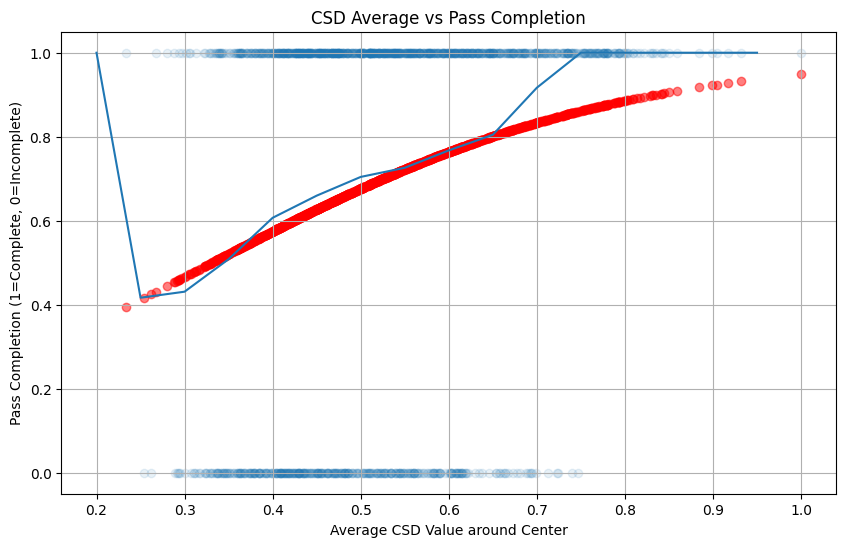

In [ ]:
if(False):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from scipy.stats import binom

    # -----------------------------
    # Bin contested-space values
    # -----------------------------
    bin_size = 0.05
    bins = np.arange(0, 1 + bin_size, bin_size)

    df_combined['avg_bin'] = pd.cut(
        df_combined['avg_value'],
        bins=bins,
        include_lowest=True
    )

    # -----------------------------
    # Empirical bin statistics
    # -----------------------------
    bin_stats = (
        df_combined
        .groupby('avg_bin')
        .agg(
            count=('yac_clipped', 'count'),
            p_emp=('yac_clipped', 'mean')
        )
        .reset_index()
    )

    # Bin centers for plotting
    bin_centers = np.array([interval.mid for interval in bin_stats['avg_bin']])

    # -----------------------------
    # Binomial confidence intervals
    # -----------------------------
    ci_low, ci_high = binom.interval(
        0.95,
        bin_stats['count'],
        bin_stats['p_emp']
    )
    ci_low = ci_low / bin_stats['count']
    ci_high = ci_high / bin_stats['count']

    # -----------------------------
    # Logistic regression curve
    # -----------------------------
    x_fit = np.linspace(0, 1, 500)

    # Use fitted coefficients explicitly (recommended)
    beta0 = -1.442885
    beta1 = 4.360768

    p_fit = 1 / (1 + np.exp(-(beta0 + beta1 * x_fit)))

    # -----------------------------
    # Plot
    # -----------------------------
    plt.figure(figsize=(7, 5))

    # Empirical probabilities
    plt.errorbar(
        bin_centers,
        bin_stats['p_emp'],
        yerr=[bin_stats['p_emp'] - ci_low, ci_high - bin_stats['p_emp']],
        fmt='o',
        color='black',
        capsize=3,
        label='Empirical probability (binned)'
    )

    # Logistic fit
    plt.plot(
        x_fit,
        p_fit,
        color='red',
        linewidth=2.5,
        label='Logistic fit'
    )

    # Formatting
    plt.xlabel('Mean contested-space value along path', fontsize=12)
    plt.ylabel('Probability of immediate tackle', fontsize=12)
    plt.title('Immediate Tackle Probability vs Contested Space', fontsize=13)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()

    plt.show()

#Output of this cell below

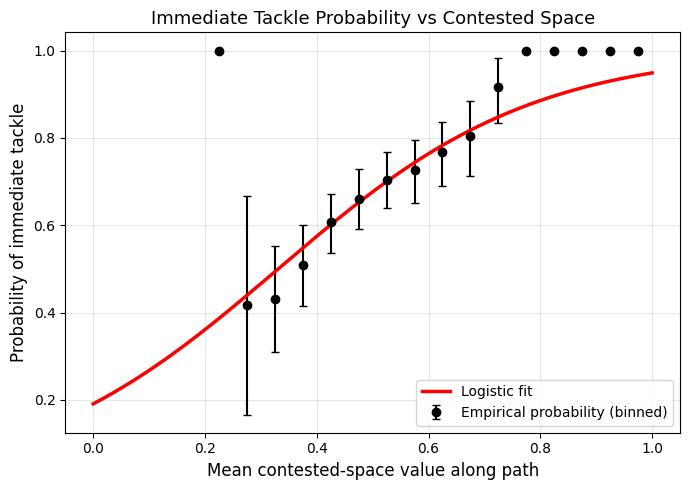

### Now we can also use the same CSDs to find the catch probability

In [ ]:
if(False):
    #range = array of all the available flat play id CSDs
    window_size = 4
    path = ''
    avg_values = [get_avg(id, path=path, window_size=window_size)[0] for id in range]

    pass_map = sup_file.drop_duplicates('flat_play_id').set_index('flat_play_id')['pass_result'].to_dict()
    pass_results = [pass_map.get(int(fid), None) for fid in range]
    arr = np.array(pass_results)
    # Convert arr to numeric: 1 if 'C', otherwise 0
    arr = np.where(arr == 'C', 1, 0).astype(int)

    # get one ball location per flat_play_id (first occurrence), then align to `range`
    ball_loc_df = df_out_merged.drop_duplicates('flat_play_id').set_index('flat_play_id')[['ball_land_x','ball_land_y']]
    ball_loc_re = ball_loc_df.reindex(range)  # missing ids become NaN

    ball_x = ball_loc_re['ball_land_x'].to_numpy()
    ball_y = ball_loc_re['ball_land_y'].to_numpy()

    # find final x,y of the "Targeted Receiver" (row with max frame_id per flat_play_id) and align to `range`
    tr = df_out_merged[df_out_merged['player_role'] == 'Targeted Receiver']
    if not tr.empty:
        idx = tr.groupby('flat_play_id')['frame_id'].idxmax()
        tr_final = tr.loc[idx].set_index('flat_play_id')[['x', 'y']]
    else:
        tr_final = pd.DataFrame(columns=['x','y'])

    tr_final_re = tr_final.reindex(range)  # missing ids become NaN
    targ_x = tr_final_re['x'].to_numpy()
    targ_y = tr_final_re['y'].to_numpy()

    # convenience structures
    target_locations = np.column_stack((targ_x, targ_y))
    target_locations_df = pd.DataFrame({'flat_play_id': range, 'target_x': targ_x, 'target_y': targ_y})


    df_summary = pd.DataFrame({
        'flatplayid': range,
        'arr': arr,
        'balllocx': ball_x,
        'balllocy': ball_y,
        'targx': targ_x,
        'targy': targ_y,
        'avg_value': avg_values
    })

    df_summary.head()

    plt.scatter(df_summary['avg_value'], df_summary['arr'], alpha=0.02)

    # compute Euclidean distance between ball landing and targeted receiver final position
    df_summary['dist_ball_targ'] = np.hypot(df_summary['balllocx'] - df_summary['targx'],
                                        df_summary['balllocy'] - df_summary['targy'])

    print(df_summary.head())

    df_summary = df_summary[df_summary['dist_ball_targ'] <= 6].reset_index(drop=True)
    # drop rows with avg_value equal to sentinel values 255 or 0
    df_summary = df_summary[~df_summary['avg_value'].isin([1, 0])].reset_index(drop=True)

    print(f"Number of plays where targeted receiver is within 2 yards of ball landing: {len(df_summary)}")
    plt.scatter(df_summary['avg_value'], df_summary['arr'], alpha=0.02)

        # train a logistic regression using avg_value to predict arr
    X = df_summary[['avg_value']].values
    y = df_summary['arr'].values

    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification report:\n", classification_report(y_test, y_pred))

    coef = float(model.coef_[0][0])
    intercept = float(model.intercept_[0])

    print(f"Logit(p) = {intercept:.6f} + {coef:.6f} * avg_value")
    print(f"p(avg_value) = 1 / (1 + exp(-({intercept:.6f} + {coef:.6f} * avg_value)))")
    print(f"Odds ratio per 1-unit increase in avg_value: {np.exp(coef):.6f}")

    if coef != 0:
        decision_boundary = -intercept / coef
        print(f"Decision boundary (p=0.5) at avg_value = {decision_boundary:.4f}")
    else:
        print("Coefficient is zero; no decision boundary.")



    # attach predictions back to df_summary
    df_summary = df_summary.copy()
    df_summary['pred_proba'] = model.predict_proba(df_summary[['avg_value']].values)[:, 1]
    df_summary['pred'] = (df_summary['pred_proba'] >= 0.5).astype(int)

    plt.figure(figsize=(10,6))

    bin_size=0.05
    bins = np.arange(0, 1 + bin_size, bin_size)
    labels = [f"{b}-{b+bin_size}" for b in bins[:-1]]
    df_summary['avg_bin'] = pd.cut(df_summary['avg_value'], bins=bins, labels=labels, right=False)

    bin_stats = df_summary.groupby('avg_bin')['arr'].agg(
        count='count',
        pct_1=lambda x: x.mean() * 100
    ).reset_index()
    bin_stats['pct_0'] = 100 - bin_stats['pct_1']

    plt.plot(bins[0:-1],bin_stats['pct_1']/100)

    plt.scatter(df_summary['avg_value'], df_summary['arr'], alpha=0.005)
    plt.scatter(df_summary['avg_value'], df_summary['pred_proba'], color='red', alpha=0.5)
    plt.xlabel('Average CSD Value around Center')
    plt.ylabel('Pass Completion (1=Complete, 0=Incomplete)')
    plt.title('CSD Average vs Pass Completion')
    plt.grid()




### Once run, you get the following:


Accuracy: 0.702726473175022

ROC AUC: 0.6368366669126874

Logit(p) = -0.687262 + 3.304681 * avg_value

p(avg_value) = 1 / (1 + exp(-(-0.687262 + 3.304681 * avg_value)))

Odds ratio per 1-unit increase in avg_value: 27.239843

Decision boundary (p=0.5) at avg_value = 0.2080


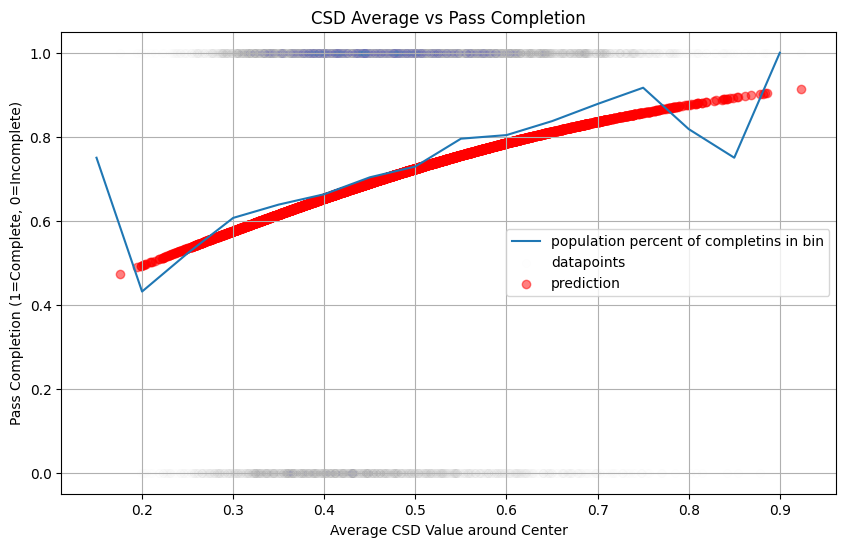

In [ ]:
if(False):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from scipy.stats import binom

    # -----------------------------
    # Bin contested-space values
    # -----------------------------
    bin_size = 0.05
    bins = np.arange(0, 1 + bin_size, bin_size)

    df_summary['avg_bin'] = pd.cut(
        df_summary['avg_value'],
        bins=bins,
        include_lowest=True
    )

    # -----------------------------
    # Empirical bin statistics
    # -----------------------------
    bin_stats = (
        df_summary
        .groupby('avg_bin')
        .agg(
            count=('arr', 'count'),
            p_emp=('arr', 'mean')
        )
        .reset_index()
    )

    # Bin centers
    bin_centers = np.array([interval.mid for interval in bin_stats['avg_bin']])

    # -----------------------------
    # Binomial confidence intervals
    # -----------------------------
    ci_low, ci_high = binom.interval(
        0.95,
        bin_stats['count'],
        bin_stats['p_emp']
    )
    ci_low = ci_low / bin_stats['count']
    ci_high = ci_high / bin_stats['count']

    # -----------------------------
    # Logistic regression curve
    # -----------------------------
    x_fit = np.linspace(0, 1, 500)

    # Replace with your fitted coefficients
    beta0 = -0.687262   # intercept from p_catch regression
    beta1 = 3.304681   # slope from p_catch regression

    p_fit = 1 / (1 + np.exp(-(beta0 + beta1 * x_fit)))

    # -----------------------------
    # Plot
    # -----------------------------
    plt.figure(figsize=(7, 5))

    # Empirical probabilities
    plt.errorbar(
        bin_centers,
        bin_stats['p_emp'],
        yerr=[bin_stats['p_emp'] - ci_low, ci_high - bin_stats['p_emp']],
        fmt='o',
        color='black',
        capsize=3,
        label='Empirical completion rate (binned)'
    )

    # Logistic fit
    plt.plot(
        x_fit,
        p_fit,
        color='red',
        linewidth=2.5,
        label='Logistic fit'
    )

    # Formatting
    plt.xlabel('Contested-space value at catch point', fontsize=12)
    plt.ylabel('Probability of completion', fontsize=12)
    plt.title('Pass Completion Probability vs Contested Space', fontsize=13)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()

    plt.show()

#Output of Cell Below

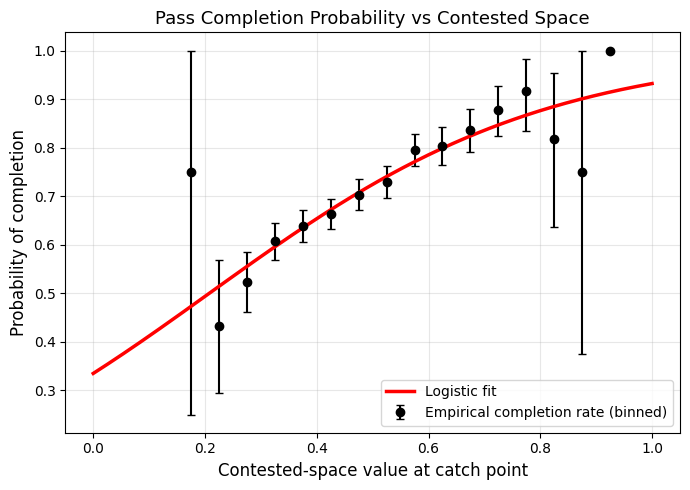